In [1]:
from pathlib import Path
import pandas as pd
from torch.utils.data import DataLoader
import torch
from tqdm import tqdm
import numpy as np
import itertools
import random
import spacy

from keras.preprocessing.sequence import pad_sequences

from transformers import BertTokenizer
from transformers import BertModel, AdamW, BertConfig
from transformers import get_linear_schedule_with_warmup
from transformers import DistilBertModel, AdamW
from transformers import BertForSequenceClassification

from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
from sklearn.linear_model import LinearRegression 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import StratifiedKFold
from pandarallel import pandarallel
pandarallel.initialize()

import os
os.chdir('..')

from src.data_lexical import LexDataset, read_lexical_corpus
from src.data_disambiguation import DisDataset, read_disambiguation_corpus
from src.model import BertForSharedTaskBaseline
from src.training import train, evaluate, forward_func_custom_bert

Using TensorFlow backend.


INFO: Pandarallel will run on 12 workers.
INFO: Pandarallel will use Memory file system to transfer data between the main process and workers.


In [2]:
import math
import os
import warnings
from dataclasses import dataclass
from typing import Optional, Tuple

import torch
import torch.utils.checkpoint
from torch import nn
from torch.nn import CrossEntropyLoss, MSELoss
from transformers import BertPreTrainedModel, BertModel
from transformers.modeling_outputs import SequenceClassifierOutput


class BertForSharedTaskMultitask(BertPreTrainedModel):

    _keys_to_ignore_on_load_unexpected = [r"pooler"]

    def __init__(self, config):
        super().__init__(config)
        self.num_labels_first_task = 1 # Regression
        self.num_labels_second_task = config.num_labels # Word sense disambiguation

        self.bert = BertModel(config)
        self.dropout_first = nn.Dropout(config.hidden_dropout_prob)
        self.dropout_second = nn.Dropout(config.hidden_dropout_prob)
        
        self.classifier_first = nn.Linear(config.hidden_size, self.num_labels_first_task)
        self.classifier_second = nn.Linear(config.hidden_size, self.num_labels_second_task)

        self.init_weights()
        

    def forward(
        self,
        input_ids=None,
        target_positions=None,
        task_id=1,
        attention_mask=None,
        token_type_ids=None,
        position_ids=None,
        head_mask=None,
        inputs_embeds=None,
        labels=None,
        output_attentions=None,
        output_hidden_states=None,
        return_dict=None,
    ):
        r"""
        labels (:obj:`torch.LongTensor` of shape :obj:`(batch_size, sequence_length)`, `optional`):
            Labels for computing the token classification loss. Indices should be in ``[0, ..., config.num_labels -
            1]``.
        """
        return_dict = return_dict if return_dict is not None else self.config.use_return_dict

        outputs = self.bert(
            input_ids,
            attention_mask=attention_mask,
            token_type_ids=token_type_ids,
            position_ids=position_ids,
            head_mask=head_mask,
            inputs_embeds=inputs_embeds,
            output_attentions=output_attentions,
            output_hidden_states=output_hidden_states,
            return_dict=return_dict,
        )

        if task_id == 1:
            pooled_output = outputs[0][torch.arange(outputs[0].size(0)), target_positions]
            pooled_output = self.dropout_first(pooled_output)
            logits = self.classifier_first(pooled_output)

            loss = None
            if labels is not None:
                if self.num_labels_first_task == 1:
                    #  We are doing regression
                    loss_fct = MSELoss()
                    loss = loss_fct(logits.view(-1), labels.view(-1))
                else:
                    loss_fct = CrossEntropyLoss()
                    loss = loss_fct(logits.view(-1, self.num_labels), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return SequenceClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )
        elif task_id == 2:
            sequence_output = outputs[0]

            sequence_output = self.dropout_second(sequence_output)
            logits = self.classifier_second(sequence_output)

            loss = None
            if labels is not None:
                loss_fct = CrossEntropyLoss()
                # Only keep active parts of the loss
                if attention_mask is not None:
                    active_loss = attention_mask.view(-1) == 1
                    active_logits = logits.view(-1, self.num_labels_second_task)
                    active_labels = torch.where(
                        active_loss, labels.view(-1), torch.tensor(loss_fct.ignore_index).type_as(labels)
                    )
                    loss = loss_fct(active_logits, active_labels)
                else:
                    loss = loss_fct(logits.view(-1, self.num_labels_second_task), labels.view(-1))

            if not return_dict:
                output = (logits,) + outputs[2:]
                return ((loss,) + output) if loss is not None else output

            return TokenClassifierOutput(
                loss=loss,
                logits=logits,
                hidden_states=outputs.hidden_states,
                attentions=outputs.attentions,
            )


In [3]:
def forward_func_multitask_same_bert(batch, device, model, additional_params):

    # Clear gradients
    model.zero_grad()    
    
    
    b_input_ids = batch['task_1']['input_ids'].to(device)
    b_input_mask = batch['task_1']['attention_mask'].to(device)
    b_labels = batch['task_1']['labels'].to(device)
    b_positions =  batch['task_1']['target_positions'].to(device)
      
    loss_1, logits = model(b_input_ids, 
                             b_positions,
                             task_id=1,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    
    b_input_ids = batch['task_2']['input_ids'].to(device)
    b_input_mask = batch['task_2']['attention_mask'].to(device)
    b_labels = batch['task_2']['labels'].to(device)

    loss_2, _ = model(b_input_ids, 
                             task_id=2,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    
    return 0.7 * loss_1 + 0.3 * loss_2, logits

In [4]:
def forward_func_multitask_bert(batch, device, model, additional_params):

    # Clear gradients
    model.zero_grad()      
    b_input_ids = batch['input_ids'].to(device)
    b_input_mask = batch['attention_mask'].to(device)
        
    if additional_params['task_id'] == 1:
        b_labels = batch['labels'].to(device)
        b_positions =  batch['target_positions'].to(device)
      
        loss, logits = model(b_input_ids, 
                             b_positions,
                             task_id=1,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    elif additional_params['task_id'] == 2:
        b_labels = batch['labels'].to(device)

        loss, logits = model(b_input_ids, 
                             task_id=2,
                             token_type_ids=None, 
                             attention_mask=b_input_mask, 
                             labels=b_labels)
    return loss, logits

In [5]:
from xml.dom import minidom
from bs4 import BeautifulSoup
from pathlib import Path
import pandas as pd
import numpy as np
import torch

class MultiDatasetSingleSource(torch.utils.data.Dataset):
    def __init__(self, encodings, labels, positions, pos_tags):
        self.encodings = encodings
        self.labels = labels
        self.pos_tags = pos_tags
        self.positions = positions

    def __getitem__(self, idx):
        item = {}
        
        task_1 = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        task_1['labels'] = torch.tensor(self.labels[idx])
        task_1['target_positions'] = torch.tensor(self.positions[idx])
        
        task_2 = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        task_2['labels'] = torch.tensor(self.pos_tags[idx])
        
        item['task_2'] = task_2
        item['task_1'] = task_1
        return item

    def __len__(self):
        return len(self.labels)

In [6]:
# Load the BERT tokenizer.
print('Loading BERT tokenizer...')
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)

Loading BERT tokenizer...


In [7]:
epochs = 20
seed_val = 2
results_window = {}
max_len = 10
stop_at = 5
cuda_card = 0
nlp = spacy.load("en_core_web_sm")

In [ ]:
import random
import numpy as np
from transformers import get_linear_schedule_with_warmup

for window_x in [0, 1, 2]:
    print('Window size of ', window_x)
    data_texts, data_corpus, data_labels, sentence_raw, target_words, positions, tags = read_lexical_corpus('data/raw/lcp_single_train.tsv',
                                                                            nlp,
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    test_texts, _, test_labels, sentences_test, test_target_words, test_positions, test_tags = read_lexical_corpus('data/raw/lcp_single_trial.xlsx',
                                                                            nlp,
                                                                           return_complete_sent=False,
                                                                           window_size=window_x + 1)
    
    lex_tag_values = list(set(list(itertools.chain(*tags))))
    lex_tag_values.append("PAD")
    lex_tag2idx = {t: i for i, t in enumerate(lex_tag_values)}
    
    torch.cuda.manual_seed_all(seed_val)

    kf = StratifiedKFold(8, shuffle=True, random_state=0)

    history_preds_val = []
    history_preds_test = []
    history_samples_val = []
    history_samples_test = []
    history_input = []
    history_input_test = []
    history_target = []
    history_target_test = []
    history_index = []
    history_index_test = []
    history_labels_val = []
    history_labels_test = []
    history_occur_text = []
    history_occur_target = []
    ix_fold = 0

    for train_index, val_index in kf.split(data_texts, data_corpus):
        print('Starting a new fold ...')
        
        train_index = list(train_index)
        random.seed(seed_val)
        random.shuffle(train_index)
        train_index = np.array(train_index)

        train_texts_lex, train_labels_lex, train_positions_lex, train_target_words_lex, train_tags_lex = data_texts[train_index], data_labels[train_index], positions[train_index], target_words[train_index], tags[train_index]
        val_texts_lex, val_labels_lex, val_positions_lex, val_target_words_lex, val_tags_lex = data_texts[val_index], data_labels[val_index], positions[val_index], target_words[val_index], tags[val_index]

        train_encodings_lex = tokenizer(list(train_texts_lex), truncation=True, padding=True)        
        data_tags = pad_sequences([[lex_tag2idx.get(l) for l in lab] for lab in train_tags_lex],
                     maxlen=len(train_encodings_lex['input_ids'][0]), value=lex_tag2idx["PAD"], padding="post",
                     dtype="long", truncating="post")
            
        train_dataset_multi = MultiDatasetSingleSource(train_encodings_lex, train_labels_lex, train_positions_lex, data_tags)
        train_loader_multi = DataLoader(train_dataset_multi, batch_size=16)

        val_encodings_lex = tokenizer(list(val_texts_lex), truncation=True, padding=True, )
        val_dataset_lex = LexDataset(val_encodings_lex, val_labels_lex, val_positions_lex)
        val_loader_lex = DataLoader(val_dataset_lex, batch_size=1)
        
        test_encodings = tokenizer(list(test_texts), truncation=True, padding=True)
        test_dataset = LexDataset(test_encodings, test_labels, test_positions)
        test_loader = DataLoader(test_dataset, batch_size=1, )
        
        all_text = ' '.join(train_texts_lex)
        occurence_text = [all_text.count(w) for w in val_target_words_lex]
        
        occurence_target = [train_target_words_lex.tolist().count(w) for w in val_target_words_lex]
        
        device = torch.device(f"cuda:{cuda_card}")
        
        model = BertForSharedTaskMultitask.from_pretrained(
            "bert-base-uncased", 
            num_labels = len(lex_tag2idx), 
            output_attentions = False, 
            output_hidden_states = False, 
        )
        model.cuda(cuda_card)

        optimizer = AdamW(model.parameters(),
                          lr = 2e-5, 
                          eps = 1e-8
                        )
        
        total_steps = len(train_loader_multi) * epochs
        scheduler = get_linear_schedule_with_warmup(optimizer, 
                                                    num_warmup_steps = 0, # Default value in run_glue.py
                                                    num_training_steps = total_steps)

        random.seed(seed_val)
        torch.manual_seed(seed_val)

        tracking_metrics_val = []
        tracking_logits_val = []

        tracking_metrics_test = []
        tracking_logits_test = []
        
        early_stopping = 0
        best_metric = 1000000
        
        for epoch_i in range(0, epochs):      
            print()
            print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
            train(device, model, train_loader_multi, forward_func_multitask_same_bert, optimizer, scheduler, {})
            
            _, val_logits, val_metric = evaluate(device, model, val_loader_lex, forward_func_multitask_bert, {'task_id': 1})
            _, test_logits, test_metric = evaluate(device, model, test_loader, forward_func_multitask_bert, {'task_id': 1})

            tracking_metrics_val.append(val_metric)
            tracking_logits_val.append(val_logits)

            tracking_metrics_test.append(test_metric)
            tracking_logits_test.append(test_logits)
            
            if val_metric > best_metric:
                early_stopping += 1
            else:
                best_metric = val_metric
                
            if early_stopping == stop_at:
                break
            
        index_min = np.argmin(tracking_metrics_val)
            
        history_labels_val.extend(val_labels_lex)
        history_labels_test.extend(test_labels)
        history_preds_val.extend(tracking_logits_val[index_min])
        history_preds_test.extend(tracking_logits_test[index_min])
        history_samples_val.extend(val_texts_lex)
        history_samples_test.extend(test_texts)
        history_input.extend(sentence_raw[val_index])
        history_input_test.extend(sentences_test)
        history_target.extend(target_words[val_index])
        history_target_test.extend(test_target_words)
        history_index.extend(([ix_fold] * len(val_index)))
        history_index_test.extend(([ix_fold] * len(test_texts)))
        history_occur_text.extend(occurence_text)
        history_occur_target.extend(occurence_target)
        ix_fold += 1

        print("")
        print("Training complete!")
        
        del model
        torch.cuda.empty_cache()
        
    results_val = pd.DataFrame()
    results_val['samples'] = history_samples_val
    results_val['preds'] = history_preds_val
    results_val['true'] = history_labels_val
    results_val['raw'] = history_input
    results_val['raw'] = results_val['raw'].astype(str)
    results_val['target'] = history_target
    results_val['index'] = history_index
    results_val['occur_text'] = history_occur_text
    results_val['occur_target'] = history_occur_target
    results_val['particion'] = 'val'
    
    results_test = pd.DataFrame()
    results_test['samples'] = history_samples_test
    results_test['preds'] = history_preds_test
    results_test['true'] = history_labels_test
    results_test['raw'] = history_input_test
    results_test['raw'] = results_test['raw'].astype(str)
    results_test['index'] = history_index_test
    results_test['target'] = history_target_test
    results_test['particion'] = 'test'

    results = pd.concat((results_val, results_test), axis=0)
    
    results_window[window_x] = results

Window size of  0
Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.092180

Running Validation...
  Metric: 0.070471
  Validation Loss: 0.008312

Running Validation...
  Metric: 0.081919
  Validation Loss: 0.011279

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.041710

Running Validation...
  Metric: 0.069688
  Validation Loss: 0.008136

Running Validation...
  Metric: 0.077907
  Validation Loss: 0.010380

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.031145

Running Validation...
  Metric: 0.097956
  Validation Loss: 0.013811

Running Validation...
  Metric: 0.100157
  Validation Loss: 0.014826

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.025479

Running Validation...
  Metric: 0.064639
  Validation Loss: 0.006955

Running Validation...
  Metric: 0.074707
  Validation Loss: 0.009431

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.021411

Running Validation...
  Metric: 0.066209
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.091653

Running Validation...
  Metric: 0.071502
  Validation Loss: 0.008234

Running Validation...
  Metric: 0.083799
  Validation Loss: 0.011414

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.042258

Running Validation...
  Metric: 0.076728
  Validation Loss: 0.009155

Running Validation...
  Metric: 0.084276
  Validation Loss: 0.011308

======== Epoch 3 / 20 ========
Training...
  Metric: 0.072778
  Validation Loss: 0.008413

Running Validation...
  Metric: 0.075764
  Validation Loss: 0.009146

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.025633

Running Validation...
  Metric: 0.065140
  Validation Loss: 0.007039

Running Validation...
  Metric: 0.070123
  Validation Loss: 0.009472

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.022427

Running Validation...
  Metric: 0.064957
  Validation Loss: 0.006964

Running Validation...
  Metric: 

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.098201

Running Validation...
  Metric: 0.080360
  Validation Loss: 0.010776

Running Validation...
  Metric: 0.084749
  Validation Loss: 0.013891

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.039721

Running Validation...
  Metric: 0.084131
  Validation Loss: 0.010872

Running Validation...
  Metric: 0.085898
  Validation Loss: 0.011142

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.030140

Running Validation...
  Metric: 0.070994
  Validation Loss: 0.008316

Running Validation...
  Metric: 0.075630
  Validation Loss: 0.009340

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.023908

Running Validation...
  Metric: 0.068899
  Validation Loss: 0.007909

Running Validation...
  Metric: 0.070932
  Validation Loss: 0.008542

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.020366

Running Validation...
  Metric: 0.067157
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.087562

Running Validation...
  Metric: 0.078107
  Validation Loss: 0.010038

Running Validation...
  Metric: 0.086309
  Validation Loss: 0.011862

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.042049

Running Validation...
  Metric: 0.065006
  Validation Loss: 0.007295

Running Validation...
  Metric: 0.076209
  Validation Loss: 0.010507

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.031958

Running Validation...
  Metric: 0.065805
  Validation Loss: 0.007341

Running Validation...
  Metric: 0.074266
  Validation Loss: 0.009484

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.025831

Running Validation...
  Metric: 0.065853
  Validation Loss: 0.007222

Running Validation...
  Metric: 0.075243
  Validation Loss: 0.009765

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.021979

Running Validation...
  Metric: 0.065849
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.086834

Running Validation...
  Metric: 0.070569
  Validation Loss: 0.008119

Running Validation...
  Metric: 0.078334
  Validation Loss: 0.011243

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.039943

Running Validation...
  Metric: 0.066040
  Validation Loss: 0.007248

Running Validation...
  Metric: 0.077524
  Validation Loss: 0.009959

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.030470

Running Validation...
  Metric: 0.070604
  Validation Loss: 0.008079

Running Validation...
  Metric: 0.082782
  Validation Loss: 0.010860

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.025530

Running Validation...
  Metric: 0.062874
  Validation Loss: 0.006499

Running Validation...
  Metric: 0.074097
  Validation Loss: 0.009565

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.021419

Running Validation...
  Metric: 0.067186
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.090154

Running Validation...
  Metric: 0.073179
  Validation Loss: 0.008488

Running Validation...
  Metric: 0.079727
  Validation Loss: 0.010457

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.040926

Running Validation...
  Metric: 0.069565
  Validation Loss: 0.007774

Running Validation...
  Metric: 0.076596
  Validation Loss: 0.010167

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.030310

Running Validation...
  Metric: 0.066619
  Validation Loss: 0.007138

Running Validation...
  Metric: 0.072632
  Validation Loss: 0.008875

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.024360

Running Validation...
  Metric: 0.068107
  Validation Loss: 0.007437

Running Validation...
  Metric: 0.073730
  Validation Loss: 0.009488

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.021115

Running Validation...
  Metric: 0.066362
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.096598

Running Validation...
  Metric: 0.080228
  Validation Loss: 0.010331

Running Validation...
  Metric: 0.083324
  Validation Loss: 0.010979

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.041492

Running Validation...
  Metric: 0.072703
  Validation Loss: 0.008975

Running Validation...
  Metric: 0.075743
  Validation Loss: 0.010076

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.031098

Running Validation...
  Metric: 0.068661
  Validation Loss: 0.007844

Running Validation...
  Metric: 0.070441
  Validation Loss: 0.008928

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.025650

Running Validation...
  Metric: 0.067470
  Validation Loss: 0.007505

Running Validation...
  Metric: 0.069382
  Validation Loss: 0.008570

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.021795

Running Validation...
  Metric: 0.068679
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.091251

Running Validation...
  Metric: 0.079175
  Validation Loss: 0.010529

Running Validation...
  Metric: 0.085649
  Validation Loss: 0.014325

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.042416

Running Validation...
  Metric: 0.074266
  Validation Loss: 0.009349

Running Validation...
  Metric: 0.082501
  Validation Loss: 0.011912

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.031293

Running Validation...
  Metric: 0.067402
  Validation Loss: 0.007648

Running Validation...
  Metric: 0.075079
  Validation Loss: 0.010161

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.025561

Running Validation...
  Metric: 0.066802
  Validation Loss: 0.007501

Running Validation...
  Metric: 0.073567
  Validation Loss: 0.009677

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.021845

Running Validation...
  Metric: 0.066191
  V

/home/krivas/projects/lexical_complexity/src/data_lexical.py:86: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return np.array(texts), np.array(corpus), np.array(labels), np.array(sentence_raw), np.array(target_words), np.array(positions), np.array(pos_tags)


Starting a new fold ...


Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.172417

Running Validation...
  Metric: 0.093237
  Validation Loss: 0.013222

Running Validation...
  Metric: 0.098903
  Validation Loss: 0.014703

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.062851

Running Validation...
  Metric: 0.089449
  Validation Loss: 0.012294

Running Validation...
  Metric: 0.092952
  Validation Loss: 0.013220

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.045137

Running Validation...
  Metric: 0.073531
  Validation Loss: 0.009019

Running Validation...
  Metric: 0.078780
  Validation Loss: 0.011026

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.033839

Running Validation...
  Metric: 0.068864
  Validation Loss: 0.007966

Running Validation...
  Metric: 0.076872
  Validation Loss: 0.010074

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.025922

Running Validation...
  Metric: 0.067637
  V

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSharedTaskMultitask: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPretraining model).
- This IS NOT expected if you are initializing BertForSharedTaskMultitask from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSharedTaskMultitask were not initialized from the model checkpoint at bert-base-u


======== Epoch 1 / 20 ========
Training...

  Average training loss: 0.173856

Running Validation...
  Metric: 0.090005
  Validation Loss: 0.012561

Running Validation...
  Metric: 0.099832
  Validation Loss: 0.018066

======== Epoch 2 / 20 ========
Training...

  Average training loss: 0.063012

Running Validation...
  Metric: 0.075701
  Validation Loss: 0.009566

Running Validation...
  Metric: 0.084708
  Validation Loss: 0.012828

======== Epoch 3 / 20 ========
Training...

  Average training loss: 0.043747

Running Validation...
  Metric: 0.074714
  Validation Loss: 0.009055

Running Validation...
  Metric: 0.082758
  Validation Loss: 0.012461

======== Epoch 4 / 20 ========
Training...

  Average training loss: 0.033731

Running Validation...
  Metric: 0.071915
  Validation Loss: 0.008517

Running Validation...
  Metric: 0.076764
  Validation Loss: 0.010983

======== Epoch 5 / 20 ========
Training...

  Average training loss: 0.026042

Running Validation...
  Metric: 0.071269
  V

In [10]:
for window_ix in results_window:
    results_window[window_ix]['mae'] = results_window[window_ix].apply(lambda x: mean_absolute_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['mse'] = results_window[window_ix].apply(lambda x: mean_squared_error([x.preds],[x.true]), axis=1)
    results_window[window_ix]['discrete_occur'] = results_window[window_ix].apply(lambda x: x.occur_target if (x.occur_target == 0 or x.occur_target == 1) else 2, axis=1)
    

In [12]:
for window_ix in results_window:
    print('Window of', window_ix)
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'val'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Valid:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    mae = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mae.mean()
    mse = results_window[window_ix].loc[results_window[window_ix].particion == 'test'].groupby(['index']).mse.mean()
    #r_2 = results_window[window_ix].groupby(['index']).
    print('Test:')    
    print('MAE --- Mean:', round(np.mean(mae), 4), ' Std:', round(np.std(mae), 4))
    print('MSE --- Mean:', round(np.mean(mse), 4), ' Std:', round(np.std(mse), 4))
    
    print()


Window of 0
Valid:
MAE --- Mean: 0.0649  Std: 0.002
MSE --- Mean: 0.0071  Std: 0.0005
Test:
MAE --- Mean: 0.0708  Std: 0.0025
MSE --- Mean: 0.0088  Std: 0.0007

Window of 1
Valid:
MAE --- Mean: 0.068  Std: 0.002
MSE --- Mean: 0.0078  Std: 0.0005
Test:
MAE --- Mean: 0.0732  Std: 0.0029
MSE --- Mean: 0.0096  Std: 0.0007

Window of 2
Valid:
MAE --- Mean: 0.0692  Std: 0.0021
MSE --- Mean: 0.0081  Std: 0.0005
Test:
MAE --- Mean: 0.0741  Std: 0.0019
MSE --- Mean: 0.0099  Std: 0.0006



In [13]:
for window_ix in results_window:
    df_temp = results_window[window_ix].groupby(['index', 'discrete_occur']).agg({'mse': 'mean',
                                                                         'mae': 'mean'}).reset_index()
    df_temp = df_temp.groupby('discrete_occur').agg({'mse': ['mean', 'std'],
                                          'mae': ['mean', 'std']}).reset_index()
    df_temp.columns = ['_'.join(col).strip('_') for col in df_temp.columns]
    print('Window of', window_ix)
    print(df_temp)
    print()

Window of 0
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.008754  0.001011  0.071898  0.003235
1             1.0  0.007303  0.001264  0.066715  0.005821
2             2.0  0.007164  0.000479  0.064831  0.001924

Window of 1
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.008991  0.001048  0.073226  0.003275
1             1.0  0.007909  0.001251  0.068653  0.005642
2             2.0  0.008069  0.000613  0.068378  0.002680

Window of 2
   discrete_occur  mse_mean   mse_std  mae_mean   mae_std
0             0.0  0.009298  0.001190  0.074078  0.003836
1             1.0  0.008708  0.001447  0.072156  0.006759
2             2.0  0.008336  0.000495  0.069026  0.001953



In [14]:
import spacy

nlp = spacy.load("en_core_web_sm")
def find_pos(sentence, ref):
    try:
        doc = nlp(sentence)
        for token in doc:
            if token.text == ref:
                return token.pos_
        return np.nan            
    except:
        return np.nan

In [15]:
for window_ix in results_window:
    print(window_ix)
    results_window[window_ix]['pos_label'] =  results_window[window_ix].apply(lambda x: find_pos(x.raw, x.target), axis=1)
    

0
1
2


Window size of: 0


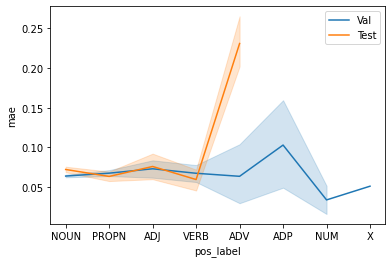

Window size of: 1


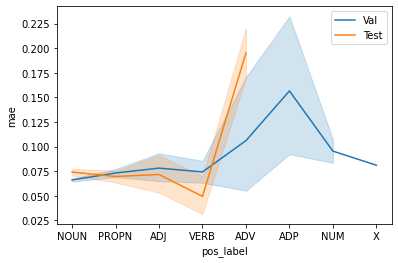

Window size of: 2


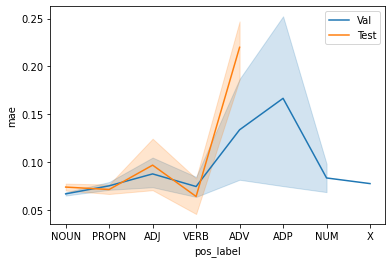

In [16]:
import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline

for window_ix in results_window:
    print('Window size of:', window_ix)
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'val')], 
                    ci=98, 
                    markers='o')
    sns.lineplot(x='pos_label', y='mae', data=results_window[window_ix].loc[(results_window[window_ix].pos_label.notnull()) &
                                                                           (results_window[window_ix].particion == 'test')], 
                    ci=98, 
                    markers='o')
    plt.legend(['Val', 'Test'])
    plt.show()